In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import tensorflow
tensorflow.random.set_seed(23)
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.constraints import Constraint
from keras import backend
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Concatenate,BatchNormalization,Add,ZeroPadding2D, ReLU
from tensorflow.keras import initializers, optimizers
from tensorflow.keras.models import Model
from numpy import ones, zeros
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 150, 150, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 74, 74, 126)  12222       concatenate[0][0]          

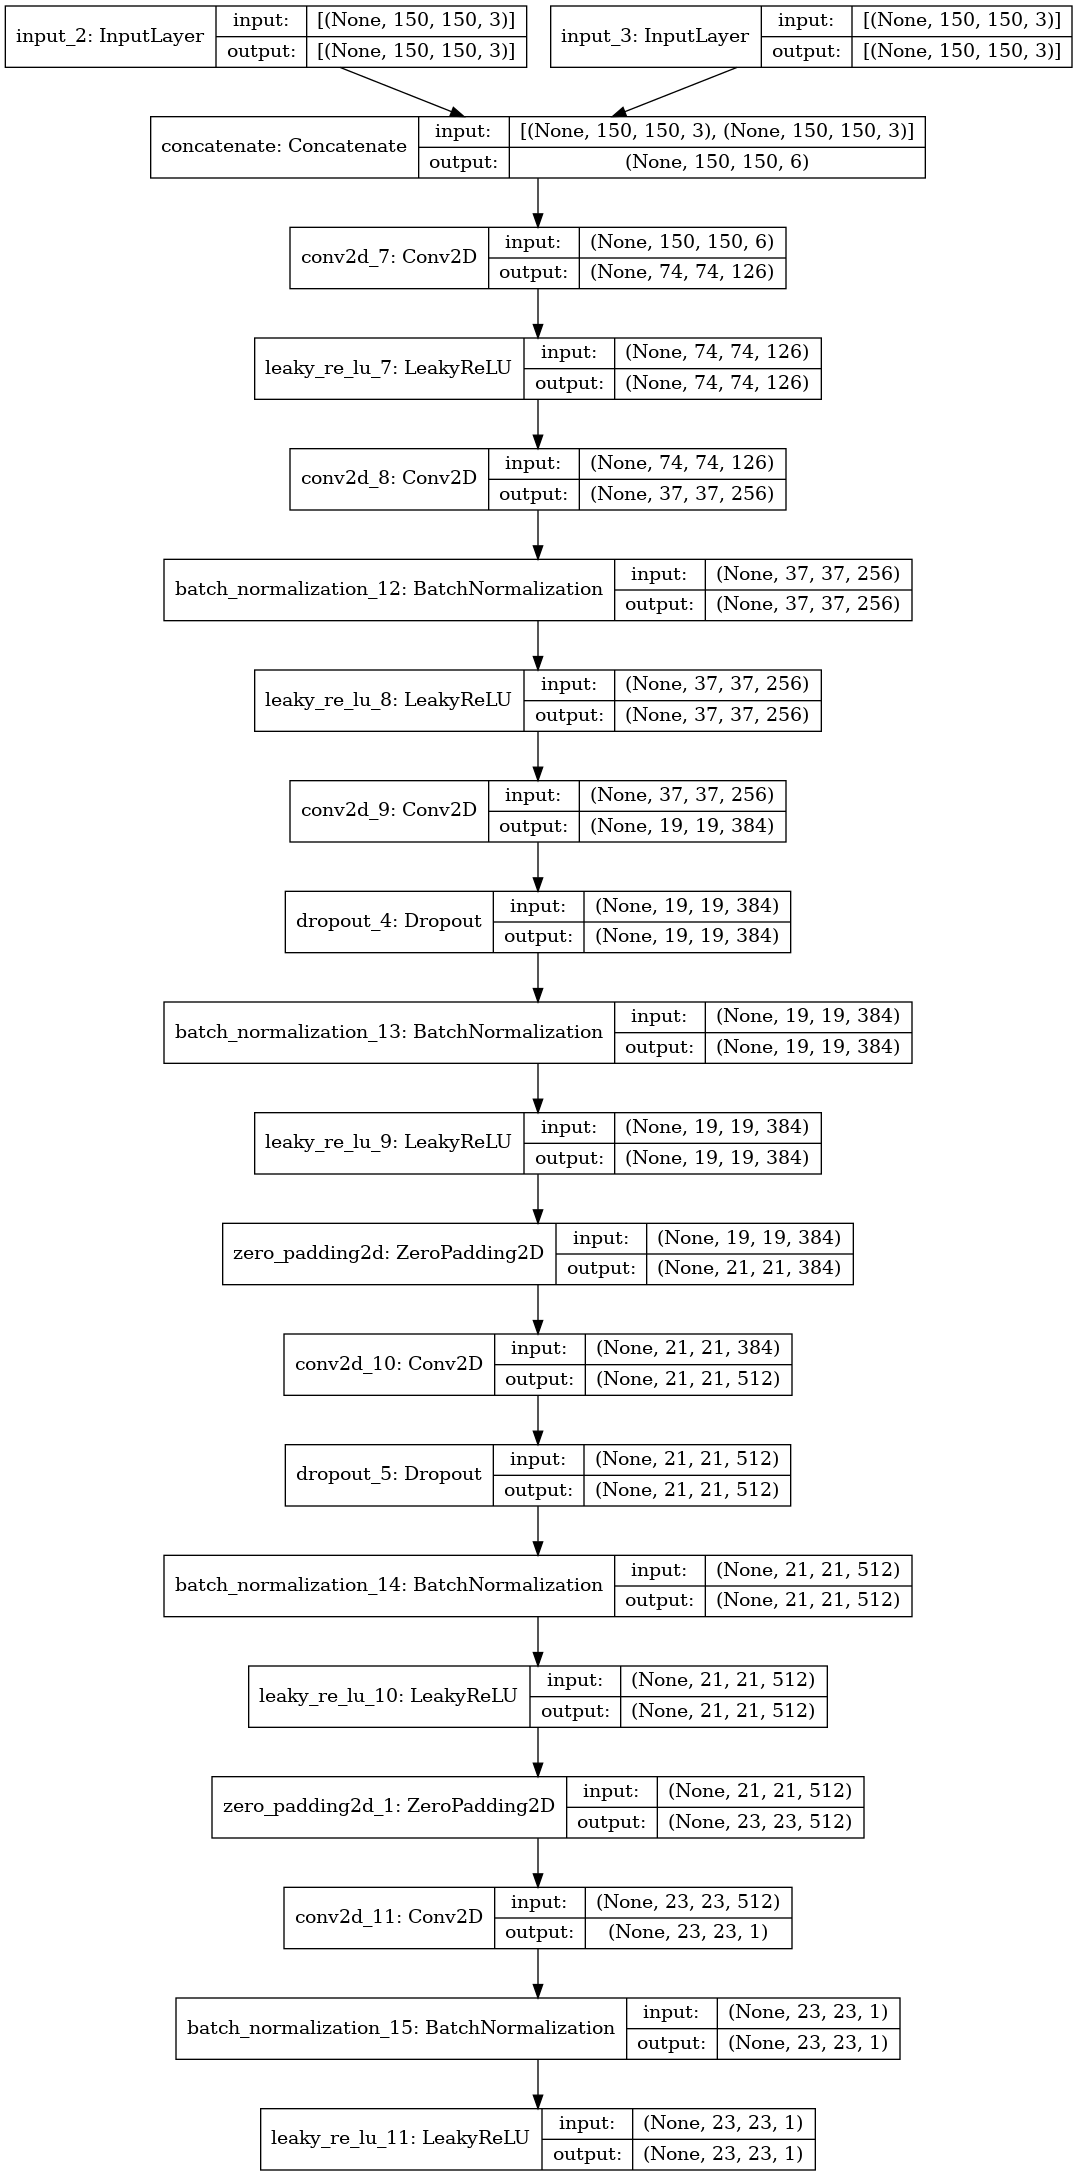

In [7]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
    

    
def discriminator():
    const = ClipConstraint(0.01)
    input_layer1 = Input((150,150,3))
    input_layer2 = Input((150,150,3))
    input_layer = Concatenate()([input_layer1, input_layer2])
    
    d1 = Conv2D(126, (4,4), (2,2),
                kernel_initializer=init,
                bias_initializer=init, kernel_constraint=const)(input_layer)
    d1 = LeakyReLU()(d1)
    
    d2 = Conv2D(256, (4,4), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init, kernel_constraint=const)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)
    
    d3 = Conv2D(384, (4,4), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init, kernel_constraint=const)(d2)
    d3 = Dropout(0.1)(d3)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU()(d3)
    p1 = ZeroPadding2D()(d3)
    
    d4 = Conv2D(512, (4,4), (1,1), padding='same', kernel_initializer=init,
                bias_initializer=init, kernel_constraint=const)(p1)
    d4 = Dropout(0.15)(d4)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU()(d4)
    p2 = ZeroPadding2D()(d4)
    
    d5 = Conv2D(1, (4,4), (1,1), padding='same', kernel_initializer=init,
                bias_initializer=init, kernel_constraint=const)(p2)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU()(d5)
    
    model = Model([input_layer1, input_layer2], outputs=d5)
    opt = optimizers.Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)
    return model

discriminator = discriminator()
print(discriminator.summary())
plot_model(discriminator,to_file='discriminator.png', show_shapes=True)

In [8]:
# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return  kernel_size + stride_size*(output_size - 1) 
# k(l-1) = k + s(k(l)-1) by backtracing

rf = receptive_field(1, 4, 1)
print(rf)

rf = receptive_field(rf, 4, 1)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70
